In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from tqdm import tqdm_notebook
from sklearn.metrics import *
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
import time
import string # библиотека для работы со строками
import re
import nltk   # Natural Language Toolkit
from sklearn.pipeline import Pipeline
warnings.filterwarnings("ignore") 

In [2]:
with open('comments_bad_good.json', encoding = 'utf-8') as json_file:
    data = json.load(json_file)

In [3]:
print(len([x["type_comment"] for x in data if x["type_comment"] == 'bad']))

88253


In [4]:
def custom_preprocessor(text):
    '''
    Make text lowercase, remove text in square brackets,remove links,remove special characters
    and remove words containing numbers.
    '''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(' +', ' ', text)
    
    return text

In [5]:
print(set([x["type_comment"] for x in data]))

{'good', 'bad'}


In [6]:
num = 300 

print("movie: ",          data[num]["name_movie"], "\n")
print("comment: \n",      data[num]["text_comment"], "\n")
print("date: ",           data[num]["date_comment"], "\n")
print("type: ",           data[num]["type_comment"], "\n")

movie:  Касабланка 

comment: 
 Одним словом - гениально! Смотрел в 'Иллюзионе' в оригинале. Поражен игрой Богарта! Финал оставил внутри очень приятное чувство! Просто хотелось улыбаться! 

Несомненно 10 из 10! 

date:  30 ноября 2006 | 23:08 

type:  good 



In [7]:
# загружаем список стоп-слов для русского
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('russian')

# примеры стоп-слов
# stop_words[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\AlexandrGnusarev\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
word_tokenizer = nltk.WordPunctTokenizer()

In [9]:
dates = [str(x) for x in np.arange(0, 2022)]
def process_data(data):
    texts = []
    targets = []
    
    # поочередно проходим по всем новостям в списке
    for item in tqdm_notebook(data):
               
#         text_lower = item['text_comment'].lower() # приводим все слова к нижнему регистру
#         text_lower = ''.join(c for c in text_lower if c not in delSymbols)
        text_lower = custom_preprocessor(item['text_comment'])
        tokens     = word_tokenizer.tokenize(text_lower) #разбиваем екст на слова
        
        # удаляем пунктуацию и стоп-слова
        tokens = [word for word in tokens if (word not in string.punctuation and word not in stop_words and word not in dates)]
        
        texts.append(tokens) # добавляем в предобработанный список
    
    return texts

In [10]:
# запускаем нашу предобработку
y = [item['type_comment'] for item in data]
texts = process_data(data)

  0%|          | 0/176506 [00:00<?, ?it/s]

In [11]:
# process_data(data[8]['type_comment'])

In [12]:
# example
i = 300
print("Label: ", y[i])
print("Tokens: ", texts[i][:20])

Label:  good
Tokens:  ['одним', 'словом', 'гениально', 'смотрел', 'иллюзионе', 'оригинале', 'поражен', 'игрой', 'богарта', 'финал', 'оставил', 'внутри', 'очень', 'приятное', 'чувство', 'просто', 'хотелось', 'улыбаться', 'несомненно']


In [13]:
# загружаем библиотеку для лемматизации
import pymorphy2 # Морфологический анализатор

# инициализируем лемматизатор :)
morph = pymorphy2.MorphAnalyzer()

In [14]:
# применяем лемматизацию ко всем текстам
for i in tqdm_notebook(range(len(texts))):           # tqdm_notebook создает шкалу прогресса :)
    text_lemmatized = [morph.parse(x)[0].normal_form for x in texts[i]] # применяем лемматизацию для каждого слова в тексте
    texts[i] = ' '.join(text_lemmatized)                # объединяем все слова в одну строку через пробел

  0%|          | 0/176506 [00:00<?, ?it/s]

In [15]:
# посмотрим на пример
i = 300
print("Label: ",   y[i])
print("Text: \n",  texts[i])

Label:  good
Text: 
 один слово гениально смотреть иллюзион оригинал поразить игра богарт финал оставить внутри очень приятный чувство просто хотеться улыбаться несомненно


In [25]:
myfile = open('text_lemmatized_bad_good.txt', mode='wt', encoding='utf-8')

for lines in texts:
    myfile.write(lines + '\n')
myfile.close

<function TextIOWrapper.close()>

In [17]:
# Функция для кодирования лейблов
def label2num(y):
    if y == 'good':
        return 1
    if y == 'bad':
        return -1
    if y == 'neutral':
        return 0

encoded_y = [label2num(yy) for yy in y]

In [18]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_y, test_y = train_test_split(texts, encoded_y, test_size=0.2, random_state=42, stratify = y)

In [19]:
vectorizer = TfidfVectorizer(max_df = 0.7,
            max_features = 194,
            min_df = 0.1,
            norm = 'l2',
            ngram_range=(1,1)) # возмем топ 200 слов
# vectorizer.fit(train_texts)

In [20]:
train_X = vectorizer.fit_transform(train_texts)
test_X  = vectorizer.transform(test_texts)

In [21]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression(C = 1.0, penalty = 'l2', solver = 'saga', random_state = 0)

lg.fit(train_X, train_y)

preds = lg.predict(test_X)

print(classification_report(test_y, preds))

              precision    recall  f1-score   support

          -1       0.79      0.79      0.79     17651
           1       0.79      0.79      0.79     17651

    accuracy                           0.79     35302
   macro avg       0.79      0.79      0.79     35302
weighted avg       0.79      0.79      0.79     35302



In [22]:
confusion_matrix(test_y, preds)

array([[13902,  3749],
       [ 3721, 13930]], dtype=int64)

если убрать из рассмотрения нейтральные рецензии, то результат получается намного лучше 0,79 против 0,56.

In [29]:
x_tv=train_X.toarray()

imdb_data_len = x_tv.shape[:][0]
reviewLength = x_tv.shape[:][1]

positive_list = [0] * reviewLength
negative_list = [0] * reviewLength
# neutral_list = [0] * reviewLength

positive_amount = 0
negative_amount = 0
# neutral_amount = 0

def addVectorizedReviewRow(lst, reviewLst, reviewLength):
    for i in range(reviewLength):
        lst[i] = lst[i] + reviewLst[i]
    return lst

def normalizeVectorizedReviewRow(lst, reviewLength, amount):
    for i in range(reviewLength):
        lst[i] = lst[i] / amount
    return lst

for i in range(imdb_data_len):
    if y[i] == 'good':
        positive_list = addVectorizedReviewRow(positive_list, x_tv[i], reviewLength)
        positive_amount += 1
#     elif y[i] == 'neutral':
#         neutral_list = addVectorizedReviewRow(neutral_list,x_tv[i], reviewLength)
#         neutral_amount += 1
    else:
        negative_list = addVectorizedReviewRow(negative_list,x_tv[i], reviewLength)
        negative_amount += 1
        
positive_list = normalizeVectorizedReviewRow(positive_list, reviewLength, positive_amount)
negative_list = normalizeVectorizedReviewRow(negative_list, reviewLength, negative_amount)
# neutral_list = normalizeVectorizedReviewRow(neutral_list, reviewLength, neutral_amount)

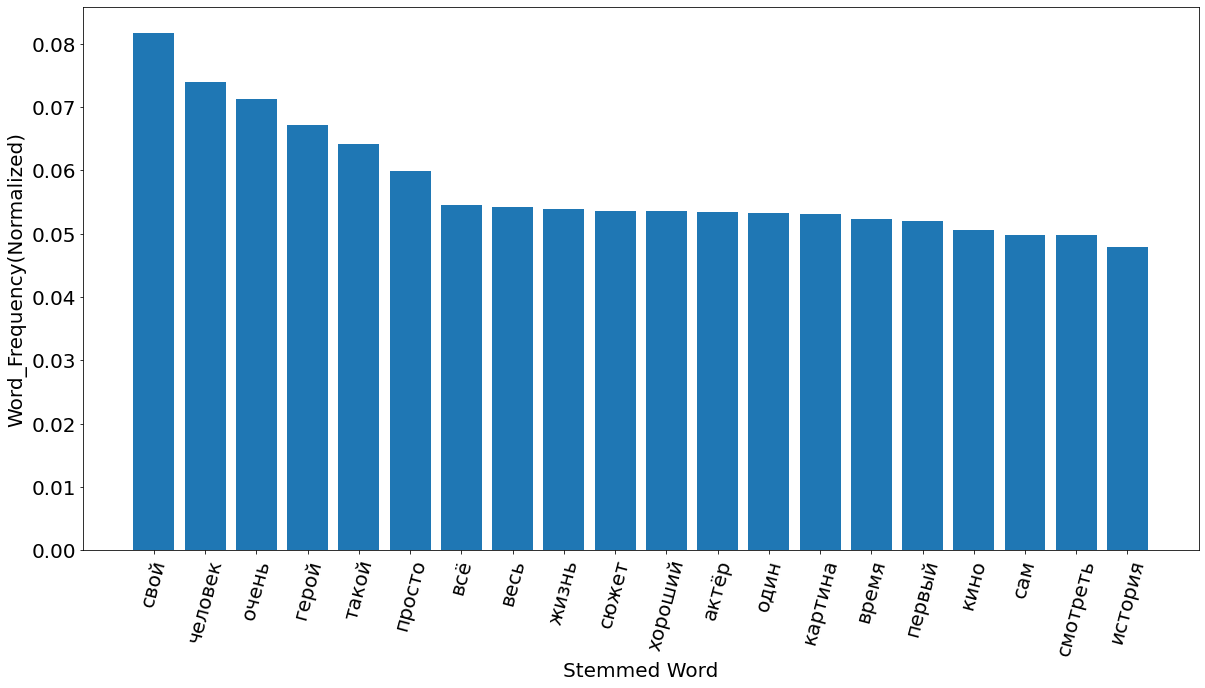

In [30]:
bow=pd.DataFrame(positive_list, vectorizer.get_feature_names())
positive_text=bow.sort_values(by=0, ascending=False).iloc[:20]

font = {'size'   : 20}

plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(positive_text.index.values, positive_text.T.iloc[:].values[0])
plt.xticks(rotation=75)
plt.xlabel("Stemmed Word")
plt.ylabel("Word_Frequency(Normalized)")
plt.show()

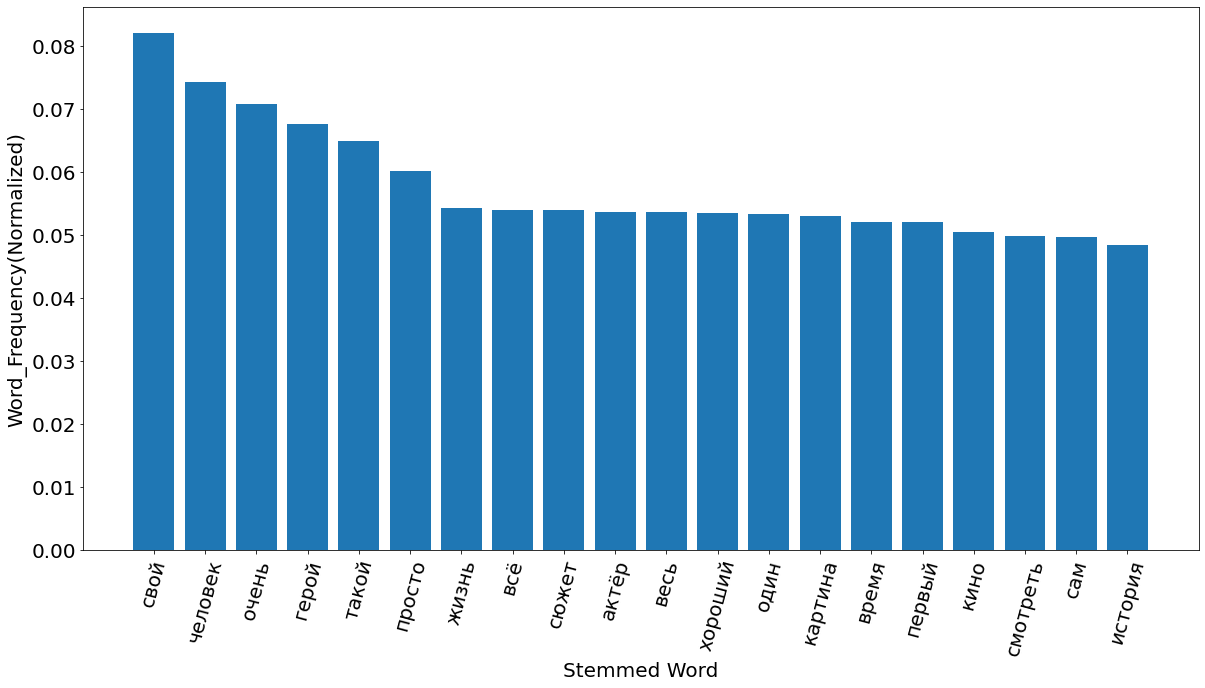

In [31]:
bow=pd.DataFrame(negative_list, vectorizer.get_feature_names())
negative_text=bow.sort_values(by=0, ascending=False).iloc[:20]

font = {'size'   : 20}

plt.rc('font', **font)

fig, ax = plt.subplots(figsize=(20, 10))

ax.bar(negative_text.index.values, negative_text.T.iloc[:].values[0])
plt.xticks(rotation=75)
plt.xlabel("Stemmed Word")
plt.ylabel("Word_Frequency(Normalized)")
plt.show()

при этом список слов все равно достаточно похож